# PLAN

- [ ] Acquisition
    - [ ] Select what list of repos to scrape.
    - [ ] Get requests form the site.
    - [ ] Save responses to csv.
- [ ] Preparation
    - [ ] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [161]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

import unicodedata
import re
from requests import get
import json
# import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

LANGUAGES = ['JavaScript', 'Rust', 'C++', 'Python', 'Dart', 'Java', 'Go', 'CSS',
            'PHP', 'TypeScript', 'Ruby', 'HTML', 'C', 'Vue', 'C#', 'Shell',
            'Clojure', 'Objective-C', 'Swift', 'Jupyter Notebook',
            'Vim script', 'Assembly', 'Kotlin', 'Dockerfile', 'TeX', 'javascript', 'rust', 'c++', 'python', 'dart',
             'java', 'go', 'css', 'php', 'typescript', 'ruby', 'html', 'c', 'vue', 'c#', 'shell', 'clojure', 
             'objective-c', 'swift', 'jupyter notebook', 'vim script', 'assembly', 'kotlin', 'dockerfile', 'tex']

BASEURL = 'https://github.com/search?p=1&q=stars%3A%3E0&s=stars&type=Repositories'
HEADERS = {'User-Agent': 'Definitely not Sentient Attack Helicoptor'}

# ACQUIRE

First thing that needs to happen is to get the links from the most starred github repositories.

In [55]:
def get_url_list(page):
    urls = []
    response = get(BASEURL, headers=HEADERS)
    soup = BeautifulSoup(response.content)
    max_page = page + 1
    for i in range(1,max_page):
        url = 'https://github.com/search?p=' + str(i) + '&q=stars%3A%3E0&s=stars&type=Repositories'
        print(f'traversing url: {url}')
        response = get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text)
        list_of_repos = soup.find('ul', class_='repo-list')
        repository = list_of_repos.find_all('li', class_='repo-list-item')
        for h in repository:
            if h.find(attrs={'itemprop':'programmingLanguage'}):
                a = h.find('a')
                urls.append(a.attrs['href'])
        time.sleep(3)
    print(f'Scraped a total of {len(urls)} github urls.')
    urls = ['https://github.com' + url for url in urls]
    with open('github_urls.csv', 'w') as f:
        ghub_urls = csv.writer(f, delimiter=',')
        ghub_urls.writerow(urls)
    return urls


##### Function that grabs the readme text and the main language of the repo


In [3]:
def grab_readmes_and_languages(urls):
    readmes = []
    languages = []
    for url in urls:
        response = get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        # print('Retrieving README')
        if soup.find('div', class_='Box-body') == None:
            # print('Skipping because of no README')
            continue
        else:
            single_readme = soup.find('div', class_='Box-body').text
            # print('Got README')
        # print('Retrieving language')
        if soup.find('span', class_='lang') == None:
            # print('Skipping because of no language')
            continue
        else:
            repo_language = soup.find('span', class_='lang').text
            # print('Got language')
        languages.append(repo_language)
        readmes.append(single_readme)
    df = pd.DataFrame({'readme':readmes, 'language':languages})
    
    return df


##### Cleaning functions.

In [56]:
def basic_clean(string):
    """Will lowercase, normalize, and remove anything that isn't a letter, number,
    whitespace or single quote and return it."""
    clean_string = string.lower()
    clean_string = unicodedata.normalize('NFKD', clean_string).\
                    encode('ascii', 'ignore').\
                    decode('utf-8', 'ignore')
    clean_string = re.sub(r'[^a-z0-9\s]', '', clean_string)
    clean_string = clean_string.strip()
    clean_string = re.sub(r'\s+', ' ', clean_string)
    return clean_string



def tokenize(string, string_or_list='string'):
    """nltk.tokenize.ToktokTokenizer"""
    tokenizer = nltk.tokenize.ToktokTokenizer()
    if string_or_list == 'string':
        return tokenizer.tokenize(string, return_str=True)
    if string_or_list == 'list':
        return tokenizer.tokenize(string)
    
def stem(string, string_or_list='string'):
    """Returns the stems."""
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    stemmed_string = ' '.join(stems)
    if string_or_list == 'list':
        return stems
    if string_or_list == 'string':
        return stemmed_string
    
def lemmatize(string, string_or_list='string'):
    """Returns the lemmatized text."""
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    lemmatized_string = ' '.join(lemmas)
    if string_or_list == 'string':
        return lemmatized_string
    if string_or_list == 'list':
        return lemmas
    
def remove_stopwords(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + LANGUAGES
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def remove_languages(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + languages
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)

# Master function for cleaning

def readme_lem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, lemmatize)

def readme_stem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, stem)

In [5]:
# urls = get_url_list(10)

In [57]:
with open('github_urls.csv') as f:
    urls = f.readlines()
urls = urls[0].split(',')

In [58]:
len(urls)

218

In [59]:
df = grab_readmes_and_languages(urls)
df.head(10)

,readme,language
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript
1,\n996.ICU\nPlease note that there exists NO ot...,Rust
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript
4,\nReact · \nReact is a JavaScript library f...,JavaScript
5,\n\n\n\n\n\n\n\nDocumentation\n\n\n\n\n\n\n\n\...,C++
6,\nAirbnb JavaScript Style Guide() {\nA mostly ...,JavaScript
7,\n\n\n\n\n\n\n📝 Available Translations: 🇨🇳 🇹🇼 ...,C++
8,\nCreate React App \nCreate React apps with n...,JavaScript
9,\nAwesome Python \nA curated list of awesome P...,Python


# PREPARE

In [60]:
df['lemmatized'] = df.readme.apply(readme_lem)

In [61]:
df['stemmed'] = df.readme.apply(readme_stem)

In [62]:
df.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript,welcome freecodecamporgs open source codebase ...,welcom freecodecamporg open sourc codebas curr...
1,\n996.ICU\nPlease note that there exists NO ot...,Rust,996icu please note exists official account app...,996icu pleas note exist offici account app mer...
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript,supporting vuejs vuejs mitlicensed open source...,support vuej vuej mitlicens open sourc project...
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript,bootstrap sleek intuitive powerful frontend fr...,bootstrap sleek intuit power frontend framewor...
4,\nReact · \nReact is a JavaScript library f...,JavaScript,react react library building user interface de...,react react librari build user interfac declar...


In [63]:
df.language.value_counts()

JavaScript          88
Python              30
Java                18
Go                  15
C++                 12
C                    7
HTML                 7
CSS                  5
TypeScript           5
Ruby                 4
Vue                  4
Kotlin               4
Shell                3
Dart                 2
Rust                 2
Swift                2
PHP                  1
Objective-C          1
Clojure              1
Assembly             1
Dockerfile           1
Jupyter Notebook     1
TeX                  1
Vim script           1
C#                   1
Name: language, dtype: int64

In [64]:
pd.Series(' '.join(df[df.language == 'JavaScript'].lemmatized).split()).value_counts()

const                                  1169
use                                    1148
code                                   1146
function                               1026
source                                  918
react                                   874
native                                  788
example                                 731
return                                  712
using                                   670
1                                       632
top                                     609
file                                    586
back                                    573
2                                       566
value                                   524
object                                  478
new                                     441
serverless                              437
array                                   423
3                                       419
true                                    404
app                             

In [65]:
# df.lemmatized.apply(remove_stopwords, args=(languages,))

In [ ]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [96]:
languages_to_keep = df.language.value_counts()[:9].index
languages_to_keep

Index(['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'CSS',
       'TypeScript'],
      dtype='object')

In [101]:
df2 = df[df.language.isin(languages_to_keep)]
df2.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript,welcome freecodecamporgs open source codebase ...,welcom freecodecamporg open sourc codebas curr...
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript,supporting vuejs vuejs mitlicensed open source...,support vuej vuej mitlicens open sourc project...
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript,bootstrap sleek intuitive powerful frontend fr...,bootstrap sleek intuit power frontend framewor...
4,\nReact · \nReact is a JavaScript library f...,JavaScript,react react library building user interface de...,react react librari build user interfac declar...
5,\n\n\n\n\n\n\n\nDocumentation\n\n\n\n\n\n\n\n\...,C++,documentation tensorflow open source software ...,document tensorflow open sourc softwar librari...


In [113]:
pd.Series(' '.join(df2.lemmatized).split()).value_counts().reset_index()

,index,0
0,use,1686
1,code,1651
2,source,1378
3,data,1266
4,library,1259
5,function,1179
6,const,1177
7,file,1138
8,using,1115
9,example,1020


In [112]:
lang = pd.concat([df2.language.value_counts(),
                    df2.language.value_counts(normalize=True)], axis=1)
lang.columns = ['n', 'percent']
lang

,n,percent
JavaScript,88,0.470588
Python,30,0.160428
Java,18,0.096257
Go,15,0.080214
C++,12,0.064171
C,7,0.037433
HTML,7,0.037433
TypeScript,5,0.026738
CSS,5,0.026738


# EXPLORE

In [143]:
javascript_words = ' '.join(df2[df2.language == 'JavaScript']['lemmatized'])
python_words = ' '.join(df2[df2.language == 'Python']['lemmatized'])
java_words = ' '.join(df2[df2.language == 'Java']['lemmatized'])
go_words = ' '.join(df2[df2.language == 'Go']['lemmatized'])
cpp_words = ' '.join(df2[df2.language == 'C++']['lemmatized'])
c_words = ' '.join(df2[df2.language == 'C']['lemmatized'])
html_words = ' '.join(df2[df2.language == 'HTML']['lemmatized'])
typescript_words = ' '.join(df2[df2.language == 'TypeScript']['lemmatized'])
css_words = ' '.join(df2[df2.language == 'CSS']['lemmatized'])
all_words = ' '.join(df2['lemmatized'])
# all_words = ' '.join(df.text)

In [ ]:
pd.Series(javascript_words.split()).value_counts()

In [146]:
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
css_freq = pd.Series(css_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [148]:
python_freq.head()

data        684
library     629
yes         594
unknown     539
learning    497
dtype: int64

In [152]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, java_freq, go_freq,
                         cpp_freq, c_freq, html_freq, typescript_freq, css_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'go', 'cpp', 'c', 'html', 'typescript', 'css'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='python', ascending=False)

,all,javascript,python,java,go,cpp,c,html,typescript,css
data,1266,342,684,28,113,9,42,45,0,3
library,1259,223,629,33,333,19,10,11,0,1
yes,613,14,594,1,0,0,4,0,0,0
unknown,546,4,539,0,1,0,2,0,0,0
learning,569,45,497,0,13,9,0,4,1,0
system,659,168,355,7,60,11,40,15,1,2
machine,405,28,347,0,21,3,0,6,0,0
http,561,90,284,14,159,3,2,9,0,0
file,1138,586,278,13,165,20,43,23,2,8
video,481,183,273,3,6,0,4,12,0,0


Text(0.5, 1.0, 'Proportion of JavaScript vs All for the 20 most common words')

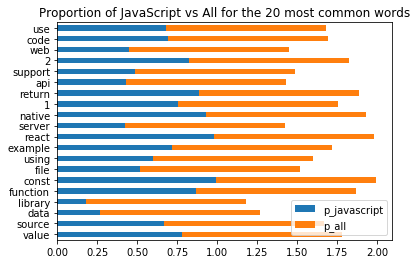

In [159]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_all=word_counts['all'] / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_all']]
 .tail(20)
 .sort_values('p_all')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs All for the 20 most common words')

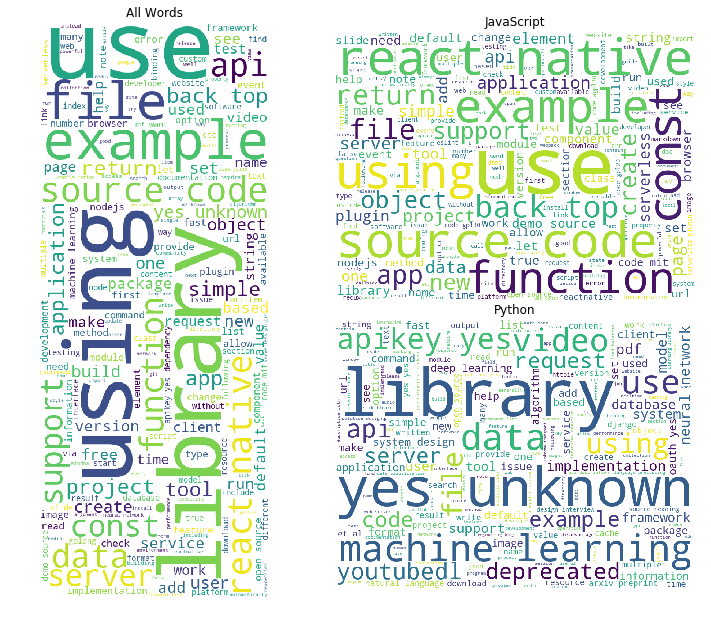

In [185]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
javascript_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(javascript_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(python_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('JavaScript')
axs[2].set_title('Python')

for ax in axs: ax.axis('off')

In [192]:
top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 2))
                      .value_counts()
                      .head(20))

top_20_javascript_bigrams.head()

(react, native)    692
(source, code)     680
(back, top)        528
(2, 3)             195
(demo, source)     190
dtype: int64

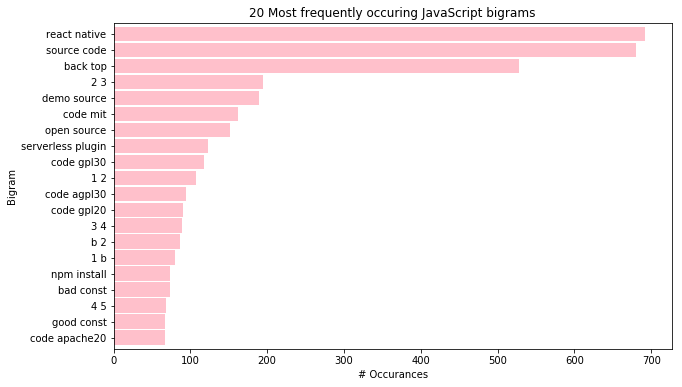

In [200]:
top_20_javascript_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_bigrams.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

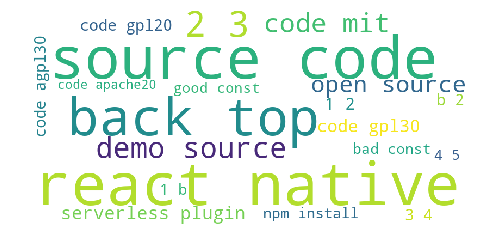

In [203]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [201]:
top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))

top_20_javascript_trigrams.head()

(demo, source, code)      190
(source, code, mit)       159
(source, code, gpl30)     118
(source, code, agpl30)     94
(source, code, gpl20)      91
dtype: int64

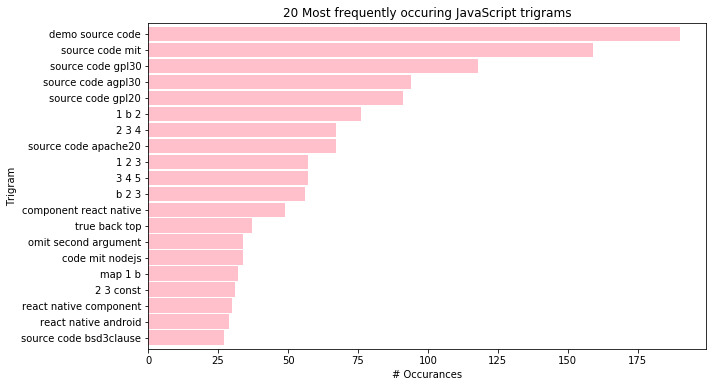

In [202]:
top_20_javascript_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_trigrams.reset_index().sort_values(by=0)['index'].\
apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

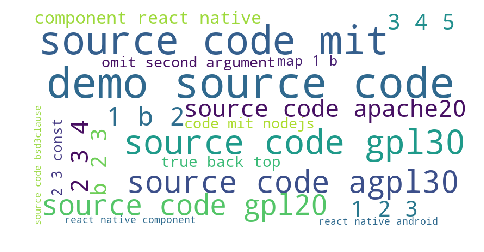

In [205]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [184]:
pd.Series(python_words.split()).value_counts()['yes']

KeyError: 'yes '

In [133]:
df2[df2.language == 'C'].head()

,readme,language,lemmatized,stemmed
73,"\nnetdata \n \n\nNetdata is distributed,...",C,netdata netdata distributed realtime performan...,netdata netdata distribut realtim perform heal...
85,\nThis README is just a fast quick start docum...,C,readme fast quick start document find detailed...,readm fast quick start document find detail do...
134,"\n\nGit - fast, scalable, distributed revision...",C,git fast scalable distributed revision control...,git fast scalabl distribut revis control syste...
155,"\n\nGit - fast, scalable, distributed revision...",C,git fast scalable distributed revision control...,git fast scalabl distribut revis control syste...
189,\nijkplayer\n\n\n\nPlatform\nBuild Status\n\n\...,C,ijkplayer platform build status android io vid...,ijkplay platform build statu android io video ...


In [127]:
python_words

'awesome curated list awesome framework library software resource inspired awesomephp awesome admin panel algorithm design pattern audio authentication build tool builtin class enhancement caching chatops tool cm code analysis commandline tool compatibility computer vision concurrency parallelism configuration cryptography data analysis data validation data visualization database driver database date time debugging tool deep learning devops tool distributed computing distribution documentation downloader ecommerce editor plugins ides email environment management file foreign function interface form functional programming game development geolocation gui hardware manipulation http image processing implementation interactive interpreter internationalization job scheduler logging machine learning miscellaneous natural language processing network virtualization networking news feed orm package management package repository permission process queue recommender system restful api robotics rp

In [125]:
javascript_words

'welcome freecodecamporgs open source codebase curriculum freecodecamporg friendly community learn code free run donorsupported 501c3 nonprofit goal helping million busy adult transition tech community already helped 10000 people get first developer job fullstack web development curriculum completely free selfpaced thousand interactive coding challenge help expand skill table content certification learning platform found bug found security issue contributing license certification freecodecamporg offer several free developer certification certification involves building 5 required web app project along hundred optional coding challenge help prepare project estimate certification take beginning programmer around 300 hour earn 30 project freecodecamporg curriculum agile user story automated test help build project incrementally ensure youve fulfilled user story submit pull test suite freecodecamps cdn mean build project website like codepen glitch even local computer development environme

In [116]:
for label in languages_to_keep:
    print(label)
    label = ' '.join(df2[df2.language == str(label)])

JavaScript
Python
Java
Go
C++
C
HTML
CSS
TypeScript


In [118]:
JavaScript

NameError: name 'JavaScript' is not defined

# MODEL